In [3]:
pip install xgboost


   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/150.0 MB 648.1 kB/s eta 0:03:52
   ---------------------------------------- 0.1/150.0 MB 726.2 kB/s eta 0:03:27
   ---------------------------------------- 0.1/150.0 MB 726.2 kB/s eta 0:03:27
   ---------------------------------------- 0.2/150.0 MB 778.2 kB/s eta 0:03:13
   ---------------------------------------- 0.3/150.0 MB 948.8 kB/s eta 0:02:38
   ---------------------------------------- 0.4/150.0 MB 1.1 MB/s eta 0:02:15
   ---------------------------------------- 0.5/150.0 MB 1.2 MB/s eta 0:02:10
   ---------------------------------------- 0.5/150.0 MB 1.2 MB/s eta 0:02:10
   ---------------------------------------- 0.6/150.0 MB 1.2 MB/s eta 0:02:04
   ---------------------------------------- 0.6/150.0 MB 1.2 MB/s eta 0:02:04
   ---------------------------------------- 0.7/150.0 MB 1.2 MB/s e


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Метрики для каждой целевой переменной:

Next_Tmax:
MAE: 0.755
RMSE: 0.996
R²: 0.895

Next_Tmin:
MAE: 0.541
RMSE: 0.697
R²: 0.921

Время выполнения: 0.99 секунд


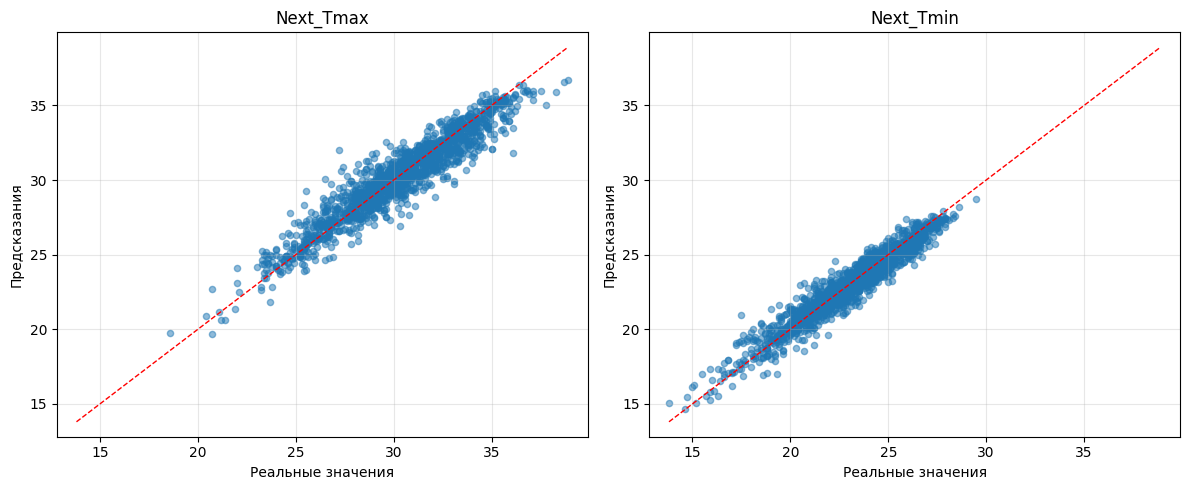

In [4]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Загрузка данных
file_path = 'Bias_correction_ucl.csv'
df = pd.read_csv(file_path, encoding='utf-8')

# Предобработка данных
df_cleaned = df.dropna()
excluded_cols = ['Date', 'station', 'Next_Tmax', 'Next_Tmin']
X = df_cleaned.drop(columns=excluded_cols)
y = df_cleaned[['Next_Tmax', 'Next_Tmin']]

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Создание и обучение модели Gradient Boosting
start_time = time.time()
model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
)
model.fit(X_train, y_train)
end_time = time.time()

# Предсказания
y_pred = model.predict(X_test)

# Вычисление метрик
metrics = {}
for i, target in enumerate(['Next_Tmax', 'Next_Tmin']):
    mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred[:, i]))
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    
    metrics[target] = {
        'MAE': round(mae, 3),
        'RMSE': round(rmse, 3),
        'R²': round(r2, 3)
    }

# Вывод результатов
print("Метрики для каждой целевой переменной:")
for target, values in metrics.items():
    print(f"\n{target}:")
    print(f"MAE: {values['MAE']}")
    print(f"RMSE: {values['RMSE']}")
    print(f"R²: {values['R²']}")

print(f"\nВремя выполнения: {round(end_time - start_time, 2)} секунд")

# Визуализация
plt.figure(figsize=(12, 5))
targets = ['Next_Tmax', 'Next_Tmin']

for i, target in enumerate(targets):
    plt.subplot(1, 2, i+1)
    plt.scatter(y_test.iloc[:, i], y_pred[:, i], alpha=0.5, s=20)
    min_val = min(y_test.min().min(), y_pred.min())
    max_val = max(y_test.max().max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1)
    plt.xlabel('Реальные значения', fontsize=10)
    plt.ylabel('Предсказания', fontsize=10)
    plt.title(target, fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xlim(min_val-1, max_val+1)
    plt.ylim(min_val-1, max_val+1)

plt.tight_layout()
plt.show()